# Getting Started



In this guide we introduce you to the basic functionality of this package in a step
by step manner.  This is a good starting point for learning about how to use this package.

If you haven't yet, now would be a good time to install GXBeam.  It can be
installed from the Julia REPL by typing `]` (to enter the package manager) and then
running `add GXBeam`.

Now, that the package is installed we need to load it so that we can use it.  It's also
often helpful to load the LinearAlgebra package.

In [1]:
using GXBeam, LinearAlgebra
nothing #hide

The geometry we will be working with is a rotating beam with a swept tip as pictured.

![](../assets/rotating-drawing.svg)

This geometry has a fixed boundary condition on the left side of the beam and rotates
around a point 2.5 inches to the left of the beam.  We will investigating the steady
behavior of this system for a variety of RPM settings at a constant sweep of 45°.

## Creating an Assembly

The first step for any analysis is to create an object of type `Assembly`.  This
object stores the properties of each of the points and beam elements in our model.

To create an object of type Assembly we need the following:
 - An array of points
 - The starting point for each beam element
 - The ending point for each beam element
 - The frame of reference for each beam element, specified as a 3x3 direction cosine matrix
 - The stiffness or compliance matrix for each beam element
 - The mass or inverse mass matrix for each beam element, for dynamic simulations
 - The element length and midpoint, if the element is curved

We will first focus on the geometry.  We start by defining the straight section of the
beam.  This section extends from (2.5, 0, 0) to (34, 0, 0).  The local coordinate frame
for this section of the beam is the same as the global coordinate frame.  We will
discretize this section into 10 elements.

To aid with constructing the geometry we can use the `discretize_beam` function.
We pass in the length, starting point, and number of elements of the beam section to the
`discretize_beam` function.  The function returns the lengths, endpoints,
midpoints, and reference frame of each beam element.

In [2]:
# straight section of the beam
L_b1 = 31.5 # length of straight section of the beam in inches
r_b1 = [2.5, 0, 0] # starting point of straight section of the beam
nelem_b1 = 10 # number of elements in the straight section of the beam
lengths_b1, xp_b1, xm_b1, Cab_b1 = discretize_beam(L_b1, r_b1, nelem_b1)
nothing #hide

The length of each beam element is equal since we used the number of elements to define
the discretization.  Alternatively we can manually specify the discretization of the
section. The following is equivalent.

In [3]:
# normalized element endpoints in the straight section of the beam
disc_b1 = range(0, 1, length=nelem_b1+1)

# discretize straight beam section
lengths_b1, xp_b1, xm_b1, Cab_b1 = discretize_beam(L_b1, r_b1, disc_b1)

nothing #hide

We now create the geometry for the swept portion of the wing.  To do so we use the same
`discretize_beam` function, but use the additional keyword argument `frame` in
order to define the undeformed local beam frame.  The direction cosine matrix which
describes the local beam frame is
$$
\begin{bmatrix}
\hat{e_{1,x}} & \hat{e_{2,x}} & \hat{e_{3,x}} \\
\hat{e_{1,y}} & \hat{e_{2,y}} & \hat{e_{3,y}} \\
\hat{e_{1,z}} & \hat{e_{2,z}} & \hat{e_{3,z}} \\
\end{bmatrix}
$$
where $\hat{e_1}$, $\hat{e_2}$, and $\hat{e_3}$ are unit vectors which define
the axes of the local frame of reference in the body frame of reference.  This matrix
may be interpreted as a transformation matrix from the undeformed local beam frame to
the body frame.

In [4]:
sweep = 45 * pi/180

# swept section of the beam
L_b2 = 6 # length of swept section of the beam
r_b2 = [34, 0, 0] # starting point of swept section of the beam
nelem_b2 = 5 # number of elements in swept section of the beam
e1 = [cos(sweep), -sin(sweep), 0] # axis 1
e2 = [sin(sweep), cos(sweep), 0] # axis 2
e3 = [0, 0, 1] # axis 3
frame_b2 = hcat(e1, e2, e3) # transformation matrix from local to body frame
lengths_b2, xp_b2, xm_b2, Cab_b2 = discretize_beam(L_b2, r_b2, nelem_b2;
    frame = frame_b2)
nothing #hide

We will now manually combine the results of our two calls to `discretize_beam`.  Since
the last endpoint from the straight section is the same as the first endpoint of the
swept section we drop one of the endpoints when combining our results.

In [5]:
# combine elements and points into one array
nelem = nelem_b1 + nelem_b2 # total number of elements
points = vcat(xp_b1, xp_b2[2:end]) # all points in our assembly
start = 1:nelem_b1 + nelem_b2 # starting point of each beam element in our assembly
stop = 2:nelem_b1 + nelem_b2 + 1 # ending point of each beam element in our assembly
lengths = vcat(lengths_b1, lengths_b2) # length of each beam element in our assembly
midpoints = vcat(xm_b1, xm_b2) # midpoint of each beam element in our assembly
Cab = vcat(Cab_b1, Cab_b2) # transformation matrix from local to body frame
                           # for each beam element in our assembly
nothing #hide

Next we need to define the stiffness (or compliance) and mass matrices for each
beam element.

The compliance matrix is defined by the following equation
$$
\begin{bmatrix}
\gamma_{11} \\
2\gamma_{12} \\
2\gamma_{13} \\
\kappa_{1} \\
\kappa_{2} \\
\kappa_{3}
\end{bmatrix}
=
\begin{bmatrix}
   S_{11} & S_{12} & S_{13} & S_{14} & S_{15} & S_{16} \\
   S_{12} & S_{22} & S_{23} & S_{24} & S_{25} & S_{26} \\
   S_{13} & S_{23} & S_{33} & S_{34} & S_{35} & S_{36} \\
   S_{14} & S_{24} & S_{43} & S_{44} & S_{45} & S_{46} \\
   S_{15} & S_{25} & S_{35} & S_{45} & S_{55} & S_{56} \\
   S_{16} & S_{26} & S_{36} & S_{46} & S_{56} & S_{66}
\end{bmatrix}
\begin{bmatrix}
   F_{1} \\
   F_{2} \\
   F_{3} \\
   M_{1} \\
   M_{2} \\
   M_{3}
\end{bmatrix}
$$
with the variables defined as follows:
 - $\gamma_{11}$: beam axial strain
 - $2\gamma_{12}$ engineering transverse strain along axis 2
 - $2\gamma_{13}$ engineering transverse strain along axis 3
 - $\kappa_1$: twist
 - $\kappa_2$: curvature about axis 2
 - $\kappa_3$: curvature about axis 3
 - $F_i$: resultant force about axis i
 - $M_i$: resultant moment about axis i

The mass matrix is defined using the following equation
$$
\begin{bmatrix}
   P_{1} \\
   P_{2} \\
   P_{3} \\
   H_{1} \\
   H_{2} \\
   H_{3}
\end{bmatrix}
=
\begin{bmatrix}
   \mu & 0 & 0 & 0 & \mu x_{m3} & -\mu x_{m2} \\
   0 & \mu & 0 & -\mu x_{m3} & 0 & 0 \\
   0 & 0 & \mu & \mu x_{m2} & 0 & 0 \\
   0 & -\mu x_{m3} & \mu x_{m2} & i_{22} + i_{33} & 0 & 0 \\
   \mu x_{m3}  & 0 & 0 & 0 & i_{22} & -i_{23} \\
   -\mu x_{m2} & 0 & 0 & 0 & -i_{23} & i_{33}
\end{bmatrix}
\begin{bmatrix}
   V_{1} \\
   V_{2} \\
   V_{3} \\
   \Omega_{1} \\
   \Omega_{2} \\
   \Omega_{3}
\end{bmatrix}
$$
with the variables defined as follows:
 - $P$: linear momentum per unit length
 - $H$: angular momentum per unit length
 - $V$: linear velocity
 - $\Omega$: angular velocity
 - $\mu$: mass per unit length
 - $(x_{m2}, x_{m3})$: mass center location
 - $i_{22}$: mass moment of inertia about axis 2
 - $i_{33}$: mass moment of inertia about axis 3
 - $i_{23}$: product of inertia

We assume that our beam has a constant cross section with the following properties:
 - 1 inch width
 - 0.063 inch height
 - 1.06 x 10^7 lb/in^2 elastic modulus
 - 0.325 Poisson's ratio
 - 2.51 x 10^-4 lb sec^2/in^4 density

We also assume the following shear and torsion correction factors:
 - $k_y = 1.2000001839588001$
 - $k_z = 14.625127919304001$
 - $k_t = 65.85255016982444$

In [6]:
# cross section
w = 1 # inch
h = 0.063 # inch

# material properties
E = 1.06e7 # lb/in^2
ν = 0.325
ρ = 2.51e-4 # lb sec^2/in^4

# shear and torsion correction factors
ky = 1.2000001839588001
kz = 14.625127919304001
kt = 65.85255016982444

A = h*w
Iyy = w*h^3/12
Izz = w^3*h/12
J = Iyy + Izz

# apply corrections
Ay = A/ky
Az = A/kz
Jx = J/kt

G = E/(2*(1+ν))

compliance = fill(Diagonal([1/(E*A), 1/(G*Ay), 1/(G*Az), 1/(G*Jx), 1/(E*Iyy),
    1/(E*Izz)]), nelem)

mass = fill(Diagonal([ρ*A, ρ*A, ρ*A, ρ*J, ρ*Iyy, ρ*Izz]), nelem)
nothing #hide

Our case is simple enough that we can analytically calculate most values for the
compliance and mass matrices, but this is not generally the case.  For more complex
geometries/structures it may be necessary to use a cross-sectional property solver such
as
[VABS](https://www.altair.com/vabs/#:~:text=VABS%20by%20AnalySwift%2C%20is%20a%20general-purpose%20cross-sectional%20analysis,3D%20stresses%20and%20strains%20of%20slender%20composite%20structures.),
[BECAS](https://becas.dtu.dk/),
[NuMAD/BPE](https://energy.sandia.gov/programs/renewable-energy/wind-power/rotor-innovation/numerical-manufacturing-and-design-tool-numad/),
or [PreComp](https://www.nrel.gov/wind/nwtc/precomp.html).

Also note that any row/column of the stiffness and/or compliance matrix which is zero
will be interpreted as infinitely stiff in that degree of freedom.  This corresponds to a
row/column of zeros in the compliance matrix.

We are now ready to put together our assembly.

In [7]:
assembly = Assembly(points, start, stop;
   compliance = compliance,
   mass = mass,
   frames = Cab,
   lengths = lengths,
   midpoints = midpoints)
nothing #hide

At this point this is probably a good time to check that the geometry of our assembly
is correct.  We can do this by visualizing the geometry in ParaView.  We can use the
`write_vtk` function to do this.  Note that in order to visualize the generated
file yourself you will need to install ParaView separately.

In [8]:
write_vtk("rotating-geometry", assembly)

![](../assets/rotating-geometry.png)

## Point Masses

We won't be applying point masses to our model, but we will demonstrate how to do so.

Point masses are defined by using the constructor `PointMass`.  Point masses
may be attached to the center of any beam element.  By using zero length beam elements,
point masses may also be effectively attached to points.  One instance of
`PointMass` must be created for every beam element to which point masses are
attached.  These instances are then stored in a dictionary with keys corresponding to
each beam element index.

Each `PointMass` contains a 6x6 mass matrix which describes the relationship
between the linear/angular velocity of the beam element and the linear/angular momentum
of the point mass.  For a single point mass, this matrix is defined as
$$
\begin{bmatrix}
   P_{x} \\
   P_{y} \\
   P_{z} \\
   H_{x} \\
   H_{y} \\
   H_{z}
\end{bmatrix}
=
\begin{bmatrix}
   m & 0 & 0 & 0 & m p_{z} & -m p_{y} \\
   0 & m & 0 & -m p_{z} & 0 & m p_{x} \\
   0 & 0 & m & m p_{y} & -m p_{x} & 0 \\
   0 & -m p_{z} & m p_{y} & I_{xx}^* & -I_{xy}^* & -I_{xz}^* \\
   m p_{z}  & 0 & -m p_{x} & -I_{xy}^* & I_{yy}^* & -I_{yz}^* \\
   -m p_{y} & m p_{x} & 0 & -I_{xz}^* & -I_{yz}^* & I_{zz}^*
\end{bmatrix}
\begin{bmatrix}
   V_{x} \\
   V_{y} \\
   V_{z} \\
   \Omega_{x} \\
   \Omega_{y} \\
   \Omega_{z}
\end{bmatrix}
$$
where $m$ is the mass of the point mass, $p$ is the position of the point mass
relative to the center of the beam element to which it is attached, and $I^*$ is the
inertia matrix corresponding to the point mass, defined relative to the center of the
beam element.  Multiple point masses may be modeled by adding their respective mass
matrices together.

Objects of type `PointMass` may be constructed by providing the fully populated
mass matrix as described above or by providing the mass, offset, and inertia matrix of
the point mass, with the later being the inertia matrix of the point mass about its
center of gravity rather than the beam center.  To demonstrate, the following code places
a 10 kg tip mass at the end of the beam, which is rigidly attached to the center of the
final beam element

In [9]:
m = 10 # mass
p = xp_b2[end] - xm_b2[end] # relative location
J = zeros(3,3) # inertia matrix (about the point mass center of gravity)

# create dictionary of point masses
point_masses = Dict(
    nelem => PointMass(m, p, J)
    )

nothing #hide

## Defining Distributed Loads

We won't be applying distributed loads to our model, but we will demonstrate how to do so.

Distributed loads are defined by using the constructor `DistributedLoads`.  One
instance of `DistributedLoads` must be created for every beam element on which
the distributed load is applied.  These instances of `DistributedLoads` are then
stored in a dictionary with keys corresponding to each beam element index.

To define a `DistributedLoads` the assembly, element number, and distributed
load functions must be passed to `DistributedLoads`.  Possible distributed
load functions are:
- `fx`: Distributed x-direction force
- `fy`: Distributed y-direction force
- `fz`: Distributed z-direction force
- `mx`: Distributed x-direction moment
- `my`: Distributed y-direction moment
- `mz`: Distributed z-direction moment
- `fx_follower`: Distributed x-direction follower force
- `fy_follower`: Distributed y-direction follower force
- `fz_follower`: Distributed z-direction follower force
- `mx_follower`: Distributed x-direction follower moment
- `my_follower`: Distributed y-direction follower moment
- `mz_follower`: Distributed z-direction follower moment

Each of these forces/moments are specified as functions of the arbitrary coordinate `s`
($f(s)$).  The s-coordinate at the start and end of the beam element can be specified
using the keyword arguments `s1` and `s2`.

For example, the following code applies a uniform 10 pound distributed load in the
z-direction on all beam elements:

In [10]:
distributed_loads = Dict()
for ielem in 1:nelem
    distributed_loads[ielem] = DistributedLoads(assembly, ielem; fz = (s) -> 10)
end
nothing #hide

To instead use a follower force (a force that rotates with the structure) we would use
the following code:

In [11]:
distributed_loads = Dict()
for ielem in 1:nelem
    distributed_loads[ielem] = DistributedLoads(assembly, ielem;
        fz_follower = (s) -> 10)
end
nothing #hide

The units are arbitrary, but must be consistent with the units used when constructing
the beam assembly.  Also note that both non-follower and follower forces may exist
simultaneously.

It is worth noting that the distributed loads are integrated over each element when they
are created using 4-point Gauss-Legendre quadrature.  If more control over the
integration is desired one may specify a custom integration method as described in the
documentation for `DistributedLoads`.

## Defining Prescribed Conditions

Whereas distributed loads are applied to beam elements, prescribed conditions are forces
and/or displacement boundary conditions applied to points. One instance of
`PrescribedConditions` must be created for every point on which prescribed conditions
are applied.  These instances of `PrescribedConditions` are then stored in a dictionary
with keys corresponding to each point index.

Possible prescribed conditions include:
- `ux`: Prescribed x-displacement
- `uy`: Prescribed y-displacement
- `uz`: Prescribed z-displacement
- `theta_x`: Prescribed first Wiener-Milenkovic parameter
- `theta_y`: Prescribed second Wiener-Milenkovic parameter
- `theta_z`: Prescribed third Wiener-Milenkovic parameter
- `Fx`: Prescribed x-direction force
- `Fy`: Prescribed y-direction force
- `Fz`: Prescribed z-direction force
- `Mx`: Prescribed x-axis moment
- `My`: Prescribed y-axis moment
- `Mz`: Prescribed z-axis moment
- `Fx_follower`: Prescribed x-direction follower force
- `Fy_follower`: Prescribed y-direction follower force
- `Fz_follower`: Prescribed z-direction follower force
- `Mx_follower`: Prescribed x-direction follower moment
- `My_follower`: Prescribed y-direction follower moment
- `Mz_follower`: Prescribed z-direction follower moment

One can apply both force and displacement boundary conditions to the same point, but one cannot specify a force and displacement condition at the same point corresponding to the same degree of freedom.

Here we create a fixed boundary condition on the left side of the beam.

In [12]:
# create dictionary of prescribed conditions
prescribed_conditions = Dict(
    # root section is fixed
    1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0, theta_z=0)
    )

nothing #hide

Note that most problems should have at least one point where deflections and/or
rotations are constrained in order to be well-posed.

## Pre-Allocating Memory for an Analysis

At this point we have everything we need to perform an analysis.  However, since we will
be performing multiple analyses using the same assembly we can save computational time
be pre-allocating memory for the analysis.  This can be done by constructing an object
of type `System`.  The constructor for this object requires that we provide the
assembly and a flag indicating whether the system is static.

In [13]:
system = System(assembly, false)
nothing #hide

## Eliminating Unnecessary State Variables

The time needed to perform our analysis can be further reduced by removing unnecessary
state variables and equations from the system of equations.  This optimization may be
enabled by providing the identities of the points with prescribed conditions using the
`prescribed_points` keyword.

In [14]:
system = System(assembly, false; prescribed_points=[1, nelem+1])
nothing #hide

## Performing a Steady State Analysis

We're now ready to perform our steady state analyses.  This can be done by calling
`steady_state_analysis` with the pre-allocated system storage, assembly,
angular velocity, and the prescribed point conditions.  We can also perform a
linear analysis instead of a nonlinear analysis by using the `linear` keyword argument.

After each analysis we'll also construct an object of type `AssemblyState` so
that we can save the results of each analysis prior to re-using the pre-allocated
memory for the next analysis.

In [15]:
rpm = 0:25:750

linear_states = Vector{AssemblyState{Float64}}(undef, length(rpm))
for i = 1:length(rpm)

    # global frame rotation
    w0 = [0, 0, rpm[i]*(2*pi)/60]

    # perform linear steady state analysis
    _, converged = steady_state_analysis!(system, assembly,
        angular_velocity = w0,
        prescribed_conditions = prescribed_conditions,
        linear = true)

    linear_states[i] = AssemblyState(system, assembly;
        prescribed_conditions=prescribed_conditions)

end

reset_state!(system)

nonlinear_states = Vector{AssemblyState{Float64}}(undef, length(rpm))
for i = 1:length(rpm)

   # global frame rotation
   w0 = [0, 0, rpm[i]*(2*pi)/60]

    # perform nonlinear steady state analysis
    _, converged = steady_state_analysis!(system, assembly,
        angular_velocity = w0,
        prescribed_conditions = prescribed_conditions)

     nonlinear_states[i] = AssemblyState(system, assembly;
         prescribed_conditions=prescribed_conditions)

end

nothing #hide

## Post Processing Results

We can access the fields in each instance of `AssemblyState` in order to plot
various quantities of interest.  This object stores an array of objects of type
`PointState` in the field `points` and an array of objects of type
`ElementState` in the field `elements`.

The fields of `PointState` are the following:
 - `u`: point linear displacement (in the global frame)
 - `theta`: point angular displacement (in the global frame)
 - `F`: externally applied forces on the point (in the global frame)
 - `M`: externally applied moments on the point (in the global frame)

The fields of `ElementState` are the following:
 - `u`: element displacement (in the global frame )
 - `theta`: angular displacement (in the global frame)
 - `F`: resultant forces (in the deformed element coordinate frame)
 - `M`: resultant moments (in the deformed element coordinate frame)
 - `V`: linear velocity (in the deformed element coordinate frame)
 - `Omega`: angular velocity (in the deformed element coordinate frame)

To demonstrate how these fields can be accessed we will now plot the root moment and
tip deflections.

In [16]:
using Plots
pyplot()
nothing #hide

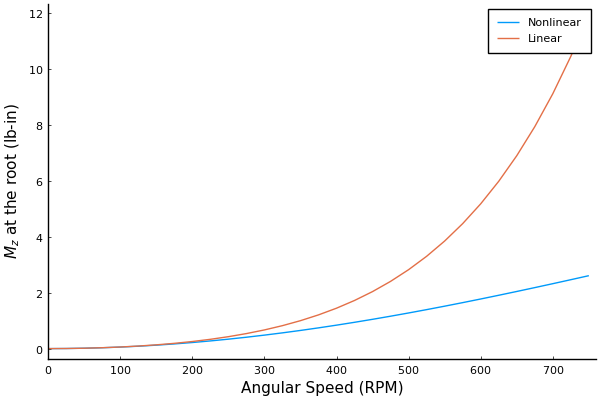

In [17]:
# root moment
plot(
    xlim = (0, 760),
    xticks = 0:100:750,
    xlabel = "Angular Speed (RPM)",
    yticks = 0.0:2:12,
    ylabel = "\$M_z\$ at the root (lb-in)",
    grid = false,
    overwrite_figure=false
    )
Mz_nl = [-nonlinear_states[i].points[1].M[3] for i = 1:length(rpm)]
Mz_l = [-linear_states[i].points[1].M[3] for i = 1:length(rpm)]
plot!(rpm, Mz_nl, label="Nonlinear")
plot!(rpm, Mz_l, label="Linear")

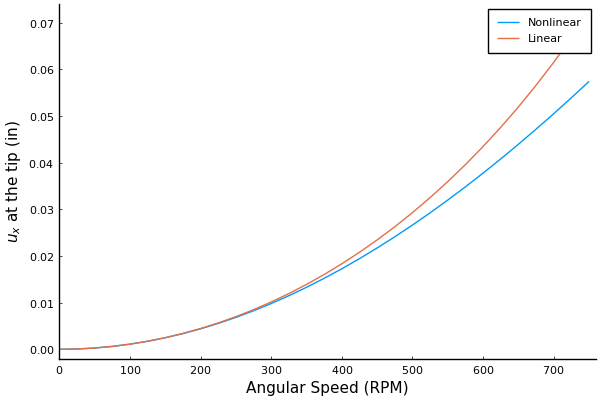

In [18]:
# x tip deflection
plot(
    xlim = (0, 760),
    xticks = 0:100:750,
    xlabel = "Angular Speed (RPM)",
    ylim = (-0.002, 0.074),
    yticks = 0.0:0.01:0.07,
    ylabel = "\$u_x\$ at the tip (in)",
    grid = false,
    overwrite_figure=false
    )
ux_nl = [nonlinear_states[i].points[end].u[1] for i = 1:length(rpm)]
ux_l = [linear_states[i].points[end].u[1] for i = 1:length(rpm)]
plot!(rpm, ux_nl, label="Nonlinear")
plot!(rpm, ux_l, label="Linear")

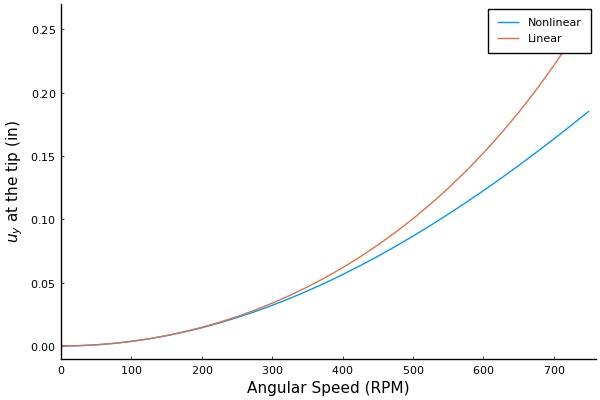

In [19]:
# y tip deflection
plot(
    xlim = (0, 760),
    xticks = 0:100:750,
    xlabel = "Angular Speed (RPM)",
    ylim = (-0.01, 0.27),
    yticks = 0.0:0.05:0.25,
    ylabel = "\$u_y\$ at the tip (in)",
    grid = false,
    overwrite_figure=false
    )
uy_nl = [nonlinear_states[i].points[end].u[2] for i = 1:length(rpm)]
uy_l = [linear_states[i].points[end].u[2] for i = 1:length(rpm)]
plot!(rpm, uy_nl, label="Nonlinear")
plot!(rpm, uy_l, label="Linear")

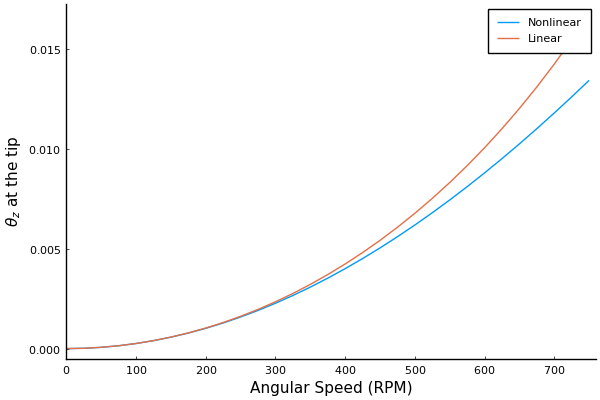

In [20]:
# rotation of the tip
plot(
    xlim = (0, 760),
    xticks = 0:100:750,
    xlabel = "Angular Speed (RPM)",
    ylabel = "\$θ_z\$ at the tip",
    grid = false,
    overwrite_figure=false
    )
theta_z_nl = [4*atan(nonlinear_states[i].points[end].theta[3]/4)
    for i = 1:length(rpm)]
theta_z_l = [4*atan(linear_states[i].points[end].theta[3]/4)
    for i = 1:length(rpm)]

plot!(rpm, theta_z_nl, label="Nonlinear")
plot!(rpm, theta_z_l, label="Linear")

## Other Capabilities

For information on how to use the other capabilities of this package see the examples or the Public API.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*